In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from lightweight_charts import Panel, chart, PlotDFAccessor, PlotSRAccessor

class RollingWindowTrainer:
    def __init__(self, train_days=5, test_days=1):
        self.train_days = train_days
        self.test_days = test_days
        self.window_size = train_days + test_days
        self.results = []
        
    def get_day_groups(self, df):
        """Group data by days using datetime index"""
        if not isinstance(df.index, pd.DatetimeIndex):
            df.index = pd.to_datetime(df.index)
        return df.groupby(df.index.date)
    
    def optimize_and_train(self, train_data, n_trials=50):
        """Optimize hyperparameters and train model on the given window"""
        X_train = train_data.drop('target', axis=1)
        y_train = train_data['target']
        
        # Use RobustScaler instead of StandardScaler to handle outliers better
        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        # Scale target variable separately to handle potential scale issues
        target_scaler = RobustScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        
        def objective(trial):
            params = {
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
                'gamma': trial.suggest_float('gamma', 0, 0.5),
                # Add more parameters for better control
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
                'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.1, 10.0)
            }
            
            model = xgb.XGBRegressor(**params, 
                                   random_state=42,
                                   early_stopping_rounds=20,
                                   eval_metric=['rmse', 'mae'])
            
            # Use cross-validation for more robust evaluation
            last_day_mask = (train_data.index.date == train_data.index.date[-1])
            X_val = X_train_scaled[last_day_mask]
            y_val = y_train_scaled[last_day_mask]
            
            try:
                model.fit(X_train_scaled, y_train_scaled,
                         eval_set=[(X_val, y_val)],
                         verbose=False)
                
                val_pred = model.predict(X_val)
                return mean_squared_error(y_val, val_pred, squared=False)
            except Exception as e:
                print(f"Error in objective function: {e}")
                return float('inf')
        
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
        
        # Train final model with best parameters
        best_params = study.best_params
        best_model = xgb.XGBRegressor(**best_params, random_state=42)
        best_model.fit(X_train_scaled, y_train_scaled)
        
        return best_model, scaler, target_scaler, study.best_value

    def run_rolling_window(self, df, n_iterations=None, n_trials=50):
        """Run rolling window analysis with improved handling of numerical stability"""
        self.results = []
        
        # Group data by days
        day_groups = self.get_day_groups(df)
        unique_days = list(day_groups.groups.keys())
        
        # Calculate maximum possible iterations
        max_iterations = len(unique_days) - self.train_days
        
        if max_iterations <= 0:
            raise ValueError(f"Dataset contains {len(unique_days)} days, but {self.train_days} training days are required.")
        
        if n_iterations is None:
            n_iterations = max_iterations
        else:
            n_iterations = min(n_iterations, max_iterations)
            
        print(f"Running {n_iterations} iterations out of maximum possible {max_iterations} iterations")
        
        for i in range(n_iterations):
            print(f"\nIteration {i+1}/{n_iterations}")
            
            train_start_idx = i
            train_end_idx = train_start_idx + self.train_days
            test_idx = train_end_idx
            
            if test_idx >= len(unique_days):
                print("Reached end of data")
                break
                
            train_days = unique_days[train_start_idx:train_end_idx]
            test_day = unique_days[test_idx]
            
            train_data = pd.concat([day_groups.get_group(day) for day in train_days])
            test_data = day_groups.get_group(test_day)
            
            print(f"Training days: {train_days[0]} to {train_days[-1]}")
            print(f"Test day: {test_day}")

            test_data_eval = test_data.copy()
            
            # Train model with improved scaling
            model, scaler, target_scaler, best_val_score = self.optimize_and_train(train_data, n_trials)
            
            # Prepare test data
            X_test = test_data.drop('target', axis=1)
            y_test = test_data['target']
            X_test_scaled = scaler.transform(X_test)
            
            # Make predictions and inverse transform to original scale
            predictions_scaled = model.predict(X_test_scaled)
            predictions = target_scaler.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()

            test_data_eval["predictions"] = predictions


            Panel(
                # auto_scale=[cdlbreakaway],
                # ohlcv=(t1data.ohlcv.data["BAC"],entries),
                histogram=[],
                right=[(test_data_eval["close"], "close") if "close" in test_data_eval.columns else ()],
                left=[],
                middle1=[(test_data_eval["predictions"],"predicictions"),(test_data_eval["target"],"target")],
                #middle2=[(X_test_temp["target"], "target")]
                ).chart(size="s", precision=4)

            #Plot predictions vs actual
            fig = go.Figure()
           # Add first y-axis (left) with predictions and target_classed
            fig.add_trace(go.Scatter(x=test_data_eval.index, y=test_data_eval["predictions"],
                                    mode='lines', name='Predictions', line=dict(color='blue')))
            fig.add_trace(go.Scatter(x=test_data_eval.index, y=test_data_eval["target"],
                                    mode='lines', name='Target', line=dict(color='orange')))


            #if there is close in data, display it
            if "close" in test_data_eval.columns:
                fig.add_trace(go.Scatter(x=test_data_eval.index, y=test_data_eval["close"],
                                        mode='lines', name='Close', line=dict(color='green'), yaxis="y2"))


            # Set up layout with dual y-axes
            fig.update_layout(
                title="Predictions and Target",
                xaxis=dict(title="Date"),
                yaxis=dict(title="Predictions and Target ", side="left"),
                yaxis2=dict(title="Close", overlaying="y", side="right"),
                legend=dict(x=0.01, y=0.99)
            )

            # Display the figure
            fig.show()            

            # Store results with additional metrics
            for idx, (timestamp, true, pred) in enumerate(zip(test_data.index, y_test, predictions)):
                self.results.append({
                    'iteration': i + 1,
                    'timestamp': timestamp,
                    'date': timestamp.date(),
                    'time': timestamp.time(),
                    'actual': true,
                    'predicted': pred,
                    'train_start': train_days[0],
                    'train_end': train_days[-1],
                    'validation_score': best_val_score,
                    'abs_error': abs(true - pred),
                    'rel_error': abs(true - pred) / (abs(true) + 1e-8)  # Avoid division by zero
                })
        
        self.results_df = pd.DataFrame(self.results)
        return self.results_df

    def evaluate_and_plot(self):
        """Enhanced evaluation with focus on prediction scale and error analysis"""
        if not hasattr(self, 'results_df'):
            print("No results to evaluate. Run rolling_window analysis first.")
            return
                
        # Calculate directional predictions
        self.results_df['actual_direction'] = (self.results_df['actual'] > 0).astype(int)
        self.results_df['pred_direction'] = (self.results_df['predicted'] > 0).astype(int)
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 30))
        gs = fig.add_gridspec(6, 2, height_ratios=[1, 1, 1, 1, 1, 1])
        
        # Plot 1: Actual vs Predicted with scale comparison
        ax1 = fig.add_subplot(gs[0, :])
        ax1.plot(self.results_df['timestamp'], self.results_df['actual'], 
                label='Actual', marker='o', alpha=0.7)
        ax1.plot(self.results_df['timestamp'], self.results_df['predicted'], 
                label='Predicted', marker='o', alpha=0.7)
        
        for date in self.results_df['date'].unique():
            ax1.axvline(x=pd.Timestamp(date), color='gray', linestyle='--', alpha=0.3)
            
        ax1.set_title('Actual vs Predicted Values (Scale Comparison)')
        ax1.legend()
        ax1.set_ylabel('Value')
        
        # Plot 2: Relative Prediction Errors
        ax2 = fig.add_subplot(gs[1, 0])
        rel_errors = self.results_df['rel_error']
        ax2.plot(self.results_df['timestamp'], rel_errors, marker='o', color='red', alpha=0.7)
        ax2.set_title('Relative Prediction Errors Over Time')
        ax2.set_ylabel('Relative Error')
        
        # Plot 3: Error Distribution
        ax3 = fig.add_subplot(gs[1, 1])
        sns.histplot(data=rel_errors, bins=30, ax=ax3)
        ax3.axvline(x=rel_errors.mean(), color='red', linestyle='--', 
                   label=f'Mean: {rel_errors.mean():.4f}')
        ax3.set_title('Relative Error Distribution')
        ax3.legend()
        
        # Plot 4: Scale Relationship
        ax4 = fig.add_subplot(gs[2, :])
        ax4.scatter(self.results_df['actual'], self.results_df['predicted'], 
                   alpha=0.5, label='Predictions')
        
        # Add regression line
        z = np.polyfit(self.results_df['actual'], self.results_df['predicted'], 1)
        p = np.poly1d(z)
        x_range = np.linspace(self.results_df['actual'].min(), 
                            self.results_df['actual'].max(), 100)
        ax4.plot(x_range, p(x_range), "r--", 
                label=f'Fit (slope: {z[0]:.4f})', alpha=0.8)
        
        # Add perfect prediction line
        ax4.plot(x_range, x_range, "g--", label='Perfect Prediction', alpha=0.8)
        ax4.set_title('Actual vs Predicted Scale Relationship')
        ax4.set_xlabel('Actual Values')
        ax4.set_ylabel('Predicted Values')
        ax4.legend()
        
        # Plot 5: Prediction Error by Magnitude
        ax5 = fig.add_subplot(gs[3, :])
        self.results_df['magnitude_bin'] = pd.qcut(abs(self.results_df['actual']), 
                                                 q=10, labels=['1', '2', '3', '4', '5',
                                                             '6', '7', '8', '9', '10'])
        error_by_magnitude = self.results_df.groupby('magnitude_bin')['rel_error'].mean()
        error_by_magnitude.plot(kind='bar', ax=ax5)
        ax5.set_title('Average Relative Error by Target Magnitude')
        ax5.set_xlabel('Target Magnitude Decile')
        ax5.set_ylabel('Average Relative Error')
        
        # Plot 6: Rolling Performance Metrics
        ax6 = fig.add_subplot(gs[4, :])
        window = min(20, len(self.results_df))
        metrics = pd.DataFrame({
            'Direction Accuracy': (self.results_df['actual_direction'] == 
                                 self.results_df['pred_direction']).rolling(window).mean(),
            'Relative Error': self.results_df['rel_error'].rolling(window).mean()
        })
        metrics.plot(ax=ax6)
        ax6.set_title(f'Rolling Performance Metrics (Window: {window})')
        ax6.legend()
        
        # Calculate and display summary statistics
        print("\nPerformance Summary:")
        print(f"Mean Relative Error: {rel_errors.mean():.4f}")
        print(f"Median Relative Error: {rel_errors.median():.4f}")
        print(f"90th Percentile Relative Error: {rel_errors.quantile(0.9):.4f}")
        
        directional_accuracy = (self.results_df['actual_direction'] == 
                              self.results_df['pred_direction']).mean()
        print(f"\nDirectional Accuracy: {directional_accuracy:.4f}")
        
        # Scale analysis
        scale_ratio = abs(self.results_df['predicted'] / self.results_df['actual'])
        print("\nScale Analysis:")
        print(f"Average Prediction/Actual Ratio: {scale_ratio.mean():.4f}")
        print(f"Median Prediction/Actual Ratio: {scale_ratio.median():.4f}")
        
        plt.tight_layout()
        return fig

Initialize trainer (select number of train_days and test days for each rolling window)

[I 2024-11-08 15:29:41,136] A new study created in memory with name: no-name-85df3d8d-4289-440f-9c12-7890b0b0661f


Running 3 iterations out of maximum possible 26 iterations

Iteration 1/3
Training days: 2024-08-01 to 2024-09-12
Test day: 2024-09-13


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-11-08 15:29:42,443] Trial 0 finished with value: 1.169860170797435 and parameters: {'max_depth': 3, 'learning_rate': 0.008538349103078293, 'n_estimators': 184, 'min_child_weight': 7, 'subsample': 0.6542388096391744, 'colsample_bytree': 0.8746458628055183, 'gamma': 0.1839573084909253, 'reg_alpha': 4.0686327280646165e-07, 'reg_lambda': 1.0202100802914027e-05, 'scale_pos_weight': 4.732108387344633}. Best is trial 0 with value: 1.169860170797435.
[I 2024-11-08 15:29:45,082] Trial 1 finished with value: 1.1806155631528559 and parameters: {'max_depth': 8, 'learning_rate': 0.0018488303054692884, 'n_estimators': 240, 'min_child_weight': 6, 'subsample': 0.819513020729908, 'colsample_bytree': 0.8152688385356694, 'gamma': 0.39822277492706554, 'reg_alpha': 0.19946998056445253, 'reg_lambda': 0.004079916589887755, 'scale_pos_weight': 5.741257856234089}. Best is trial 0 with value: 1.169860170797435.
[I 2024-11-08 15:29:46,369] Trial 2 finished with value: 1.241082705579759 and parameters: {'

[I 2024-11-08 15:29:50,864] A new study created in memory with name: no-name-a8eda3f2-cb0e-42c8-918c-73a25862a812



Iteration 2/3
Training days: 2024-08-02 to 2024-09-13
Test day: 2024-09-16


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-11-08 15:29:51,760] Trial 0 finished with value: 0.8920913386018676 and parameters: {'max_depth': 3, 'learning_rate': 0.027885583269723284, 'n_estimators': 123, 'min_child_weight': 2, 'subsample': 0.7999074833656732, 'colsample_bytree': 0.8845818223546638, 'gamma': 0.218571761623567, 'reg_alpha': 0.0012346869861376353, 'reg_lambda': 0.0036827680419658114, 'scale_pos_weight': 2.413464394425228}. Best is trial 0 with value: 0.8920913386018676.
[I 2024-11-08 15:29:53,863] Trial 1 finished with value: 0.8894739977303718 and parameters: {'max_depth': 6, 'learning_rate': 0.0059506911726079645, 'n_estimators': 201, 'min_child_weight': 7, 'subsample': 0.9485166231883408, 'colsample_bytree': 0.7477481530472944, 'gamma': 0.38170217024644004, 'reg_alpha': 0.0031103782518335163, 'reg_lambda': 0.006553947255292354, 'scale_pos_weight': 9.873717400918629}. Best is trial 1 with value: 0.8894739977303718.
[I 2024-11-08 15:29:55,175] Trial 2 finished with value: 0.8881709140682567 and parameters

[I 2024-11-08 15:30:02,943] A new study created in memory with name: no-name-2c4c1ccb-9860-4595-8bfa-12e434b01271



Iteration 3/3
Training days: 2024-08-05 to 2024-09-16
Test day: 2024-09-17


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2024-11-08 15:30:03,941] Trial 0 finished with value: 0.7179277386551308 and parameters: {'max_depth': 3, 'learning_rate': 0.05554883561956939, 'n_estimators': 101, 'min_child_weight': 4, 'subsample': 0.6826320930621704, 'colsample_bytree': 0.6577001327422376, 'gamma': 0.43714584097241116, 'reg_alpha': 0.00012119387476249144, 'reg_lambda': 3.5422794538222126e-06, 'scale_pos_weight': 0.20172904747405607}. Best is trial 0 with value: 0.7179277386551308.
[I 2024-11-08 15:30:05,622] Trial 1 finished with value: 0.7305574723002027 and parameters: {'max_depth': 4, 'learning_rate': 0.007587599473186521, 'n_estimators': 429, 'min_child_weight': 2, 'subsample': 0.6598187717085467, 'colsample_bytree': 0.6863412346556615, 'gamma': 0.08543763917837366, 'reg_alpha': 0.00875278118088143, 'reg_lambda': 9.632370190276737e-07, 'scale_pos_weight': 2.5260144862249305}. Best is trial 0 with value: 0.7179277386551308.
[I 2024-11-08 15:30:09,539] Trial 2 finished with value: 0.6659730968114214 and parame

/var/folders/8p/dwqnp65s0s77jdbm4_6z4vp80000gn/T/ipykernel_50370/959038432.py:266: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Performance Summary:
Mean Relative Error: 3.2117
Median Relative Error: 0.9012
90th Percentile Relative Error: 2.8938

Directional Accuracy: 0.6392

Scale Analysis:
Average Prediction/Actual Ratio: 3.1175
Median Prediction/Actual Ratio: 0.4865


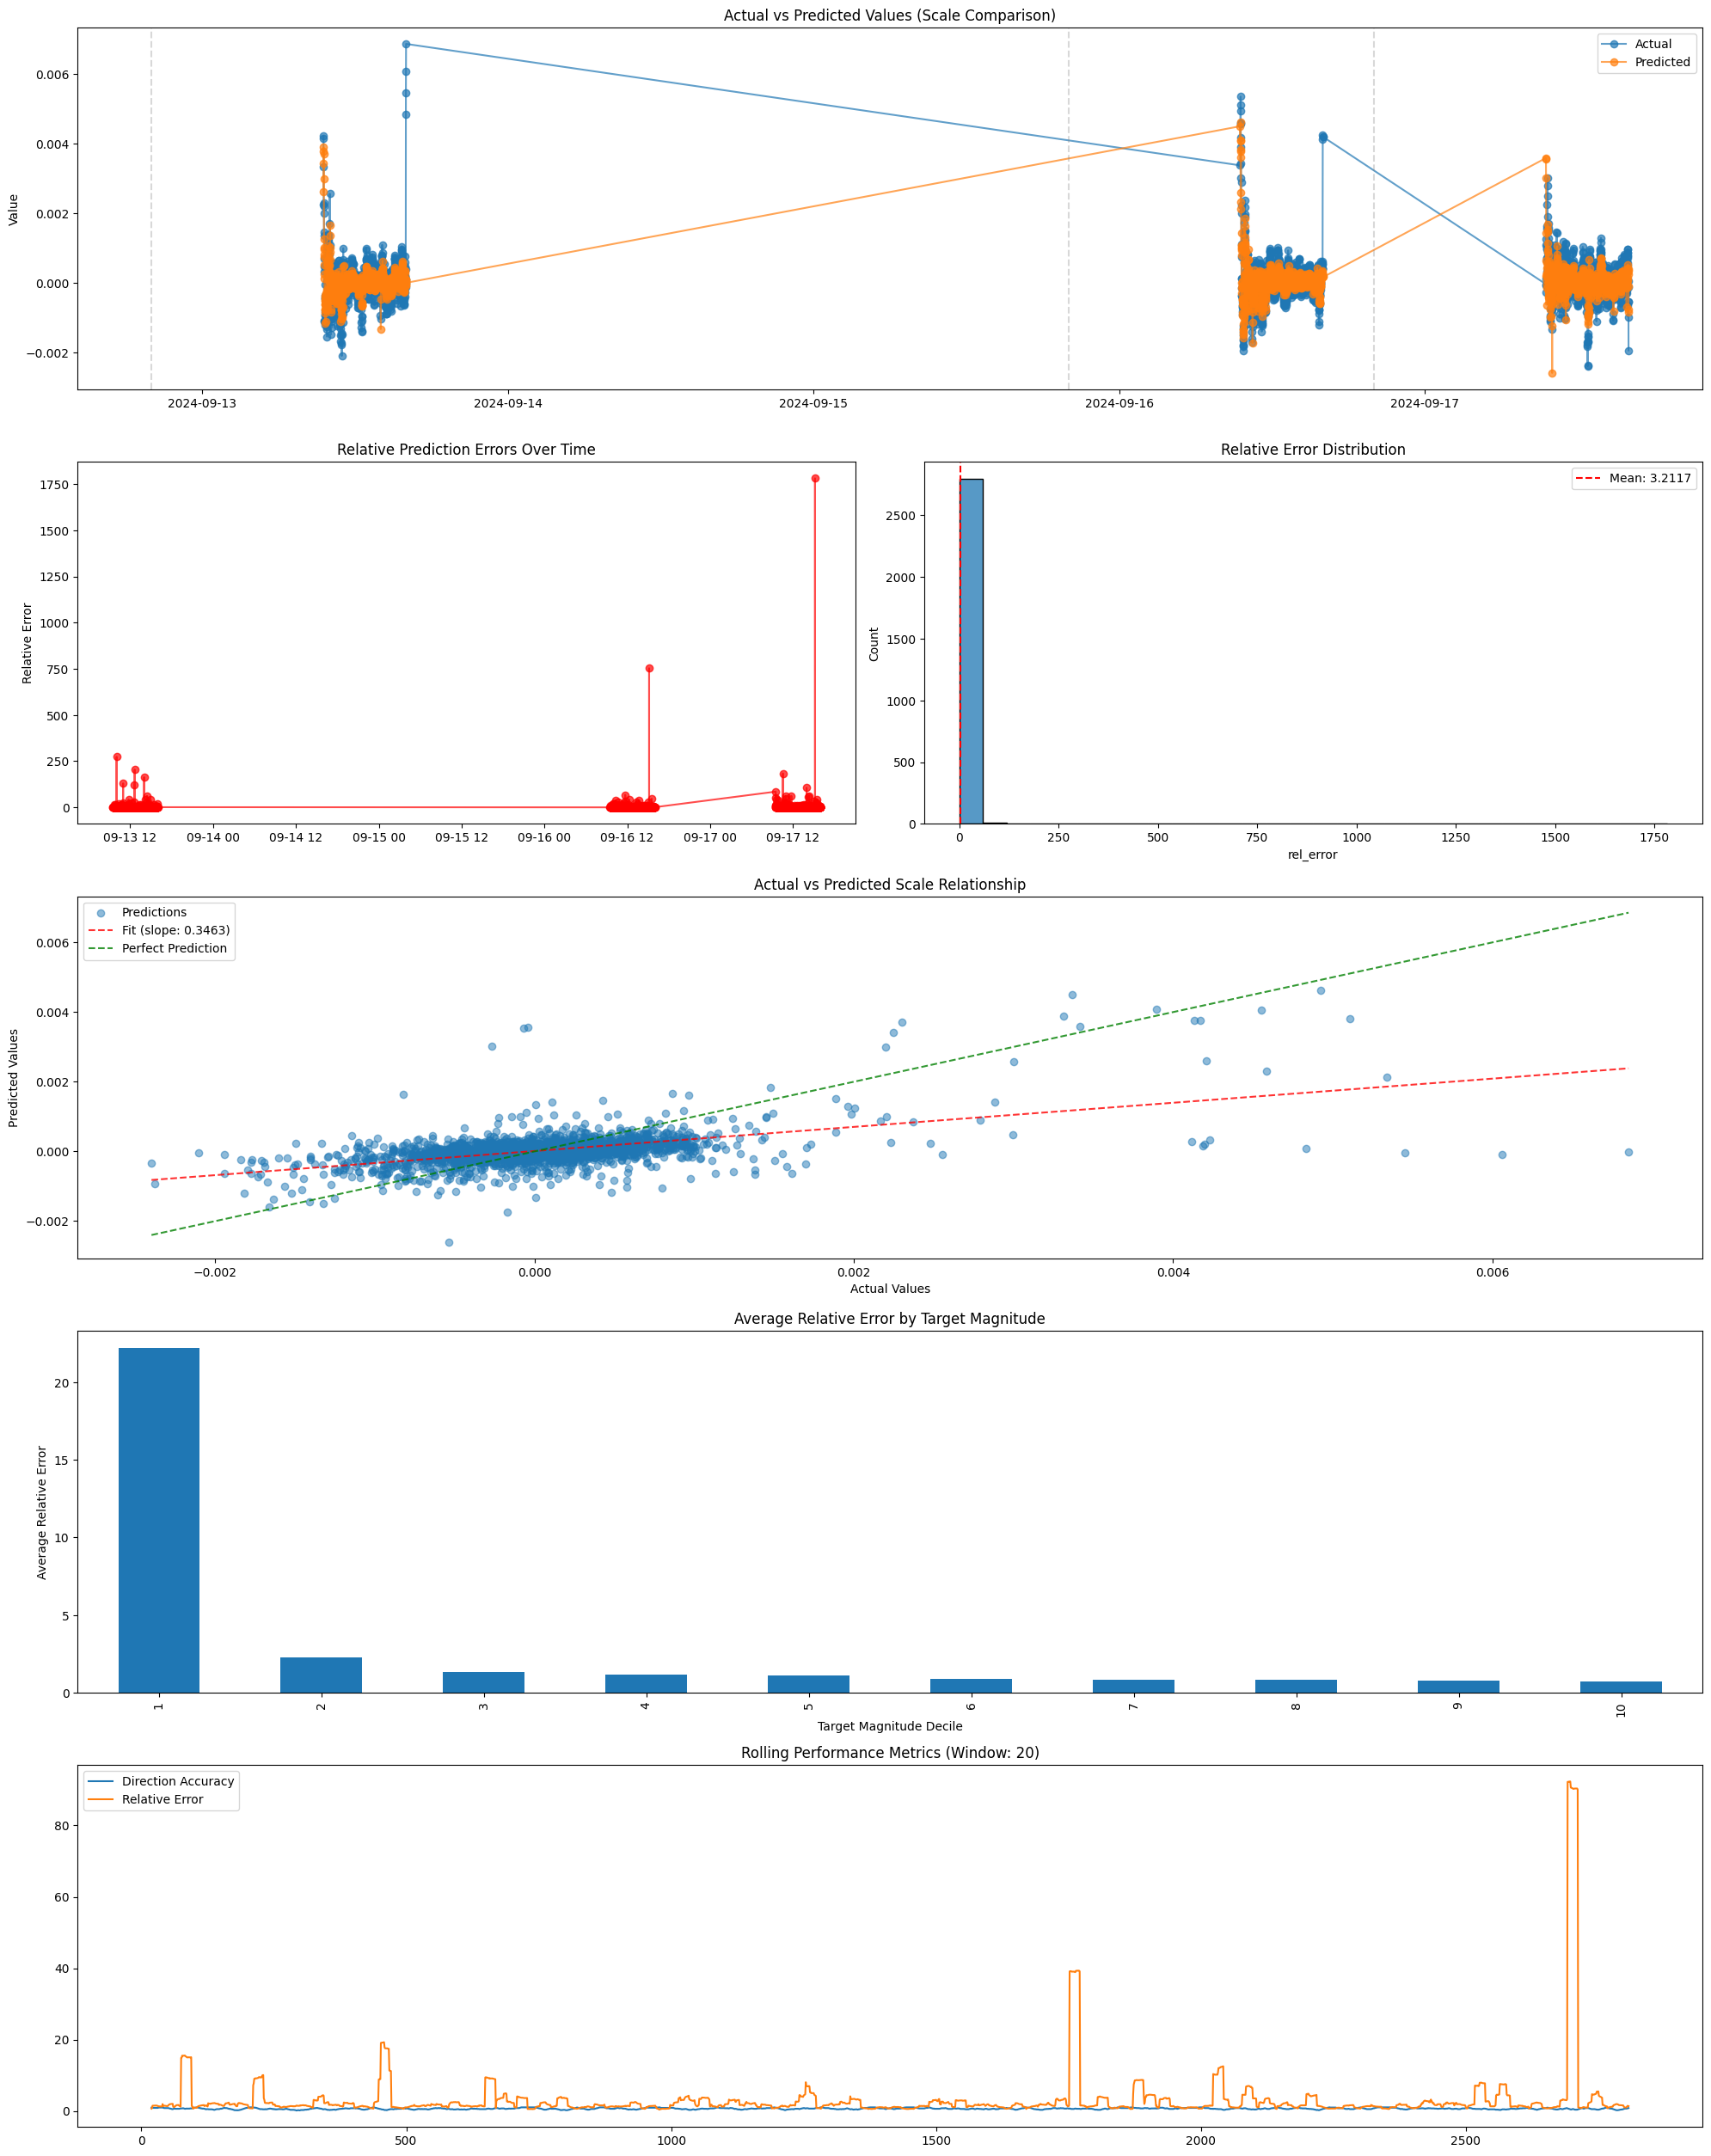

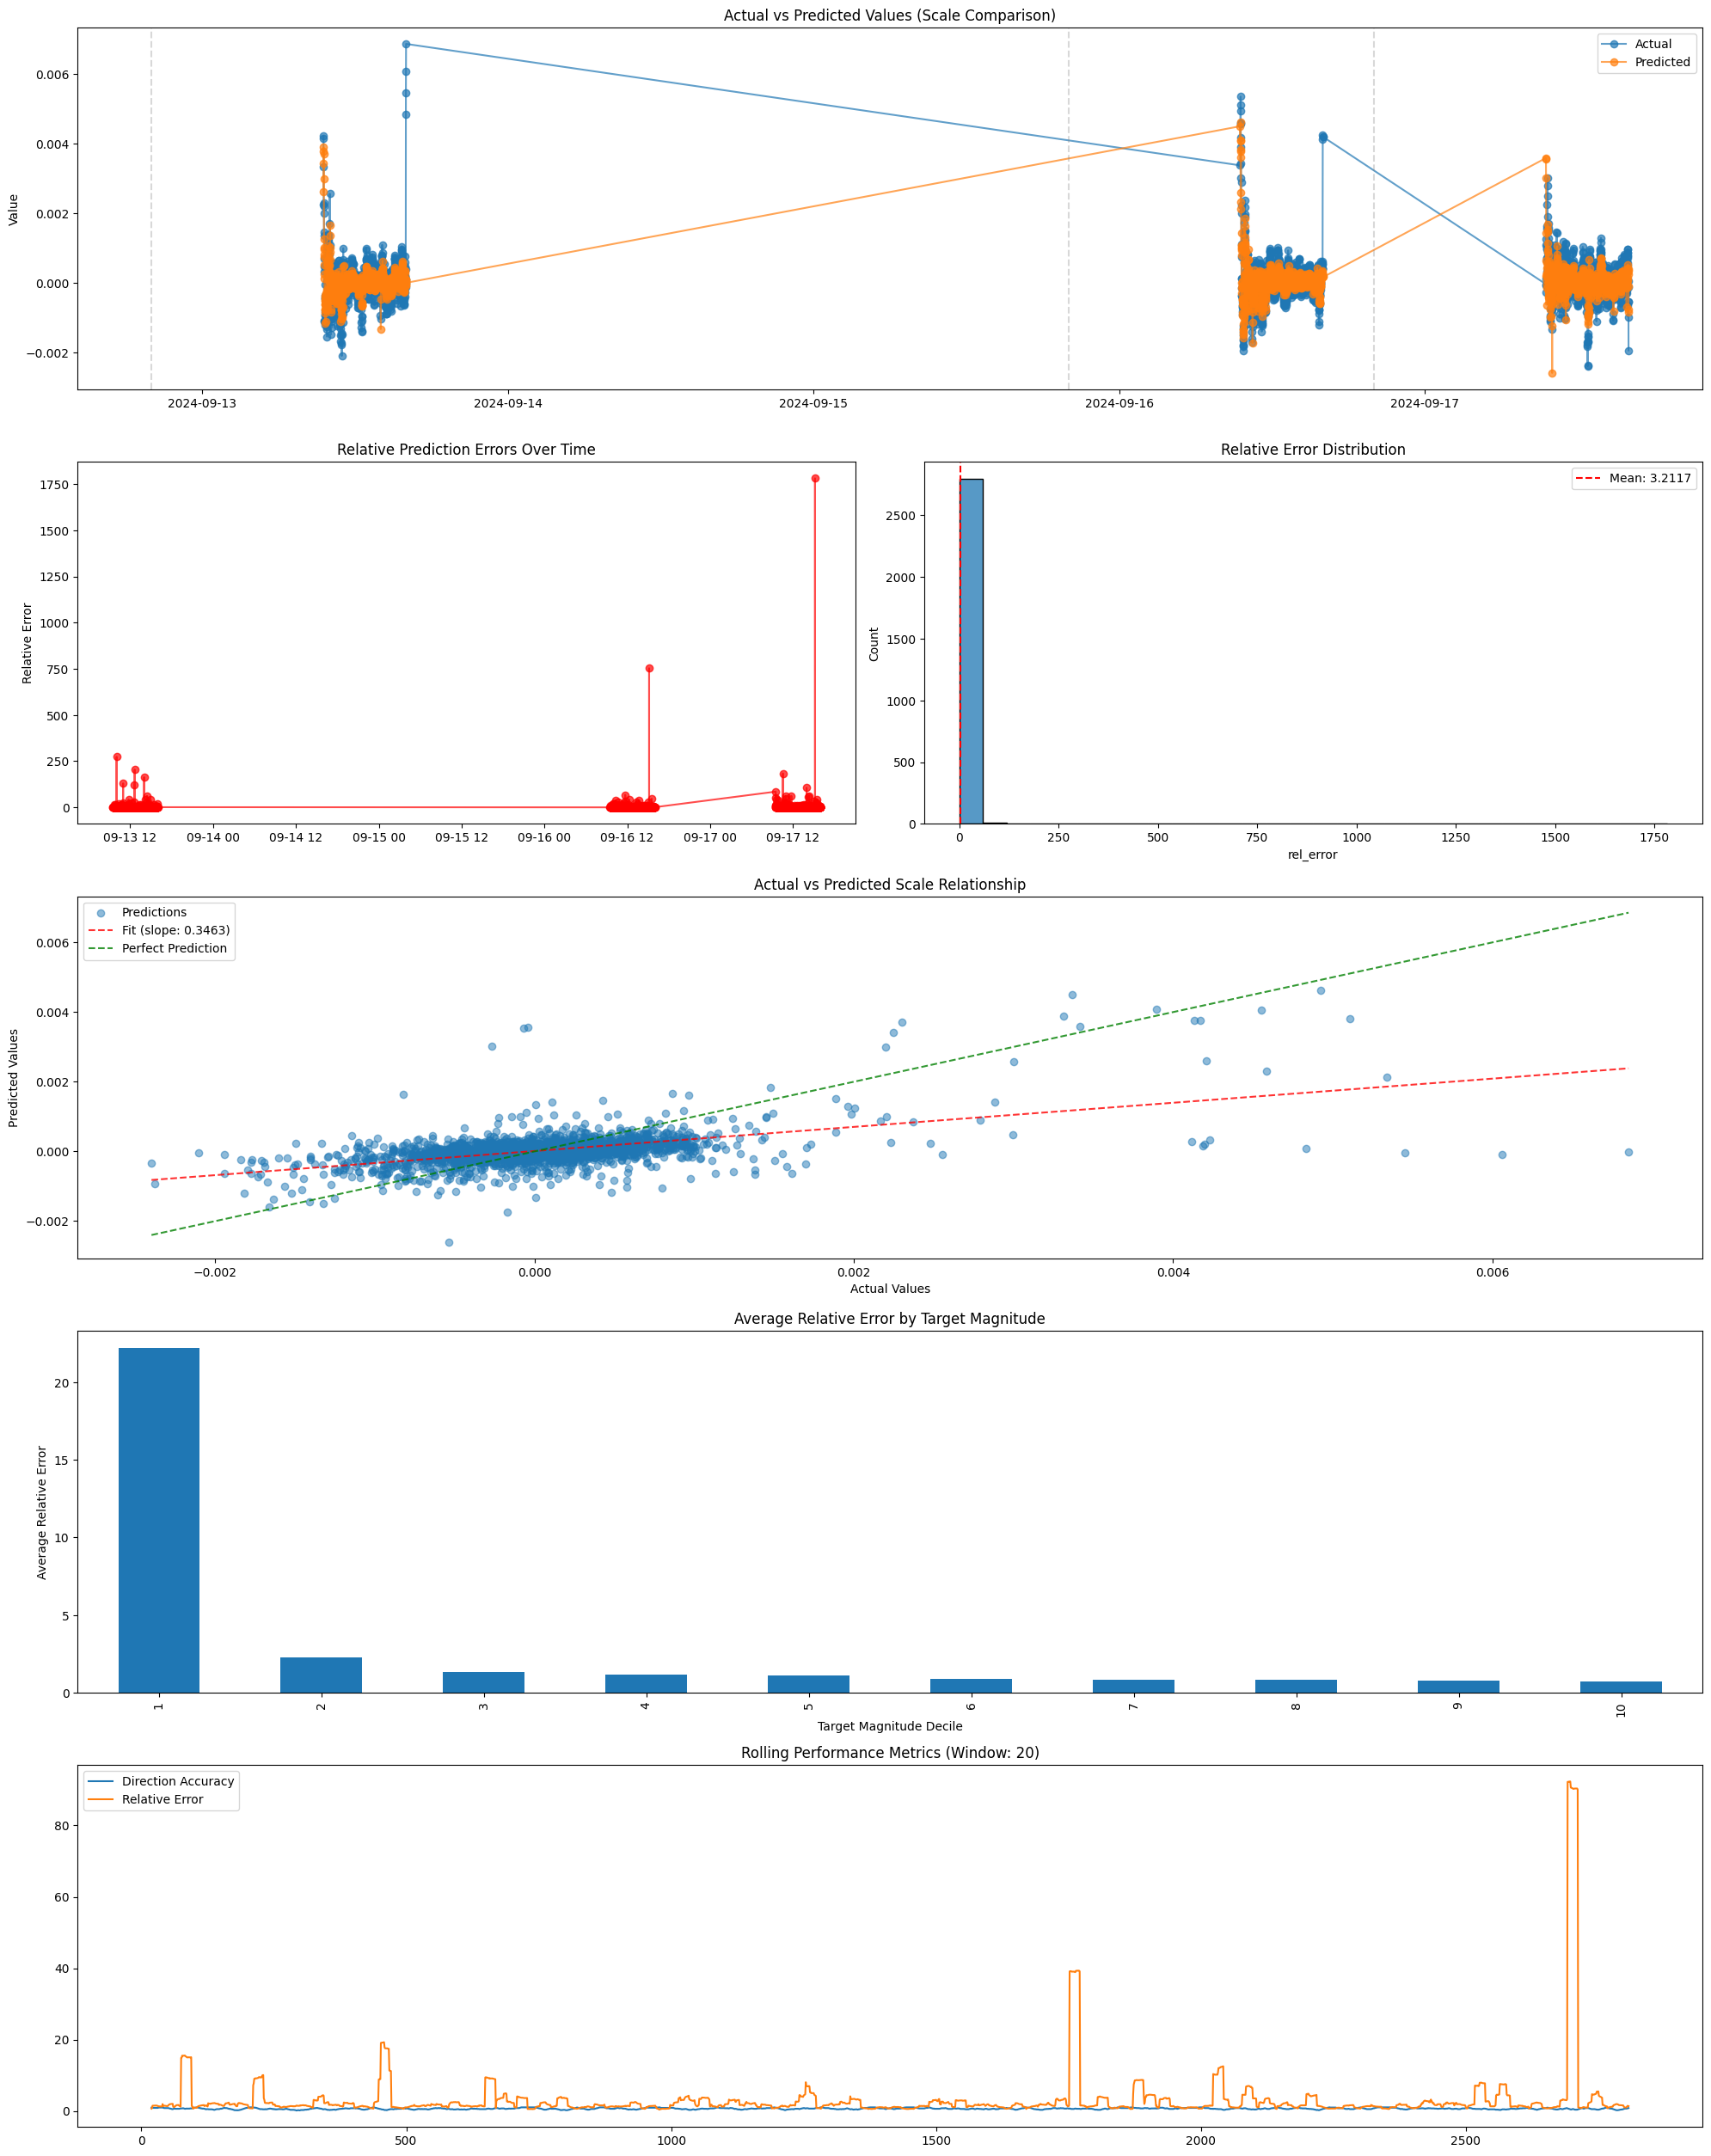

In [30]:
CSV_FILE = 'features_ma_bac_25s.csv'
# Load data
df = pd.read_csv(CSV_FILE, parse_dates=['Open time'])
df.set_index('Open time', inplace=True)

#df = df[df.index > "2024-01-09 14:00:00"]

# Initialize trainer (select number of train_days and test days for each rolling window)
trainer = RollingWindowTrainer(train_days=30, test_days=1)

# Run analysis for 3 iterations  (1 iteration = train+test)  None means entire dataset
results = trainer.run_rolling_window(df, n_iterations=3, n_trials=5)

# Plot results
trainer.evaluate_and_plot()
